### Band Pass Adjustment

https://hls.gsfc.nasa.gov/algorithms/bandpass-adjustment/


|Band Name | Slope | Offset | Residual |
|---|---|---|---|
|Coastal aerosol|0.996|-0.00023|0.0004|
|Blue|0.977|-0.00411|0.0018|
|Green|1.005|-0.00093|0.0011|
|Red|0.982|0.00094|0.0015|
|NIR|1.001|-0.00029|0.0003|
|SWIR 1|1.001|-0.00015|0.0001|
|SWIR 2|0.996|-0.00097|0.0009|

In [1]:
# Start client for multiprocessing

from dask.distributed import Client
client = Client(n_workers=6)
client

<Client: scheduler='tcp://127.0.0.1:35137' processes=6 cores=24>

In [2]:
# Geth the data 
# Load data
import sys
sys.path.append('../b_Temporal_Stack')
import regionstack
import eotempstack
import xr_eotemp

saldana = regionstack.regionStack('Saldana_training_2015')

S1 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/
Stacking S1 failed: <class 'StopIteration'>  <traceback object at 0x7fe28495da08>
Reading 8 S1 stack files
S1 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/
Stacking S1 failed: <class 'StopIteration'>  <traceback object at 0x7fe2b0194cc8>
Reading 6 S1 stack files
GLCM_S1 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/
Reading 4 GLCM_S1 stack files
GLCM_S1 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/
Reading 3 GLCM_S1 stack files
S2 object initialized from /mnt/workspace_cluster_6/TRANSVER

In [9]:
# Select dates

s2 = saldana.S2.sel(time='2015-12-21')

l8 = saldana.LC08.sel(time='2015-12-22')

In [ ]:
import numpy as np
import xarray as xr
import pandas as pd

time = xr.Variable('time', pd.DatetimeIndex(np.array([s2.time.values, l8.time.values])))
da = xr.concat([s2, l8], dim=time)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


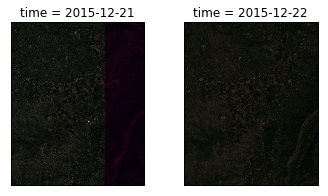

In [23]:
da.eotemp.plot_RGB()

In [77]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


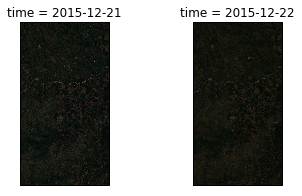

In [62]:
# Subset are with complete bands
xslice = (s2.x[0].values+0, s2.x[0].values+(s2.x[-1].values - s2.x[0].values)*2/3)
xslice

subset = da.sel(x=slice(xslice[0], xslice[1]))
subset.eotemp.plot_RGB()

In [127]:
def correct_band(dataset, band):
    
    lf_dict = {'blue':[0.977, -0.00411],'green':[1.005, -0.00093],
               'red':[0.982, 0.00094],'nir':[1.001, -0.00029],
               'swir1':[1.001,-0.00015],'swir2':[0.996,-0.00097]}
    
    # Compute original difference
    orig_diff = (dataset[band].isel(time=0) - subset.blue.isel(time=1))*0.0001
    
    # Calculate error mean and sd
    orig_error_mean = orig_diff.mean(dim=['x','y']).compute()*0.0001
    orig_error_sd = orig_diff.std(dim=['x','y']).compute()*0.0001
    
    # Apply correction
    dataset[band+'_corr'] = lf_dict[band][0]*subset[band]+lf_dict[band][1]
    
    # Calculate the difference with corrected band 
    corr_diff = (dataset[band+'_corr'].isel(time=0) - dataset[band].isel(time=1))*0.0001
    
    corr_error_mean = corr_diff.mean(dim=['x','y']).compute()*0.0001
    corr_error_sd = corr_diff.std(dim=['x','y']).compute()*0.0001
    
    print('{} original: {} +- {}'.format(band, orig_error_mean.values+0, orig_error_sd.values*2))
    print('{} corected: {} +- {}'.format(band, corr_error_mean.values+0, corr_error_sd.values*2))
    
    # Plot differences
    
    fig, axes = plt.subplots(nrows=2, ncols=2)
    # Histograms
    xr.plot.hist(orig_diff, bins=75, alpha=0.75, facecolor='blue', range=(-0.25,0.25), ax=axes[0,0])
    xr.plot.hist(corr_diff, bins=75, alpha=0.75, facecolor='green', range=(-0.25,0.25), ax=axes[0,1])
    # Maps
    orig_diff.plot(robust=True, ax=axes[1,0], cmap='RdYlBu')
    corr_diff.plot(robust=True, ax=axes[1,1], cmap='RdYlGn')
    
    plt.title('{} band: original vs. corrected'.format(band))
    plt.tight_layout()
    plt.show()
    


blue original: 1.4751554885855716e-06 +- 3.840269358937844e-06
blue corected: 1.331035533347386e-06 +- 3.75703162963713e-06


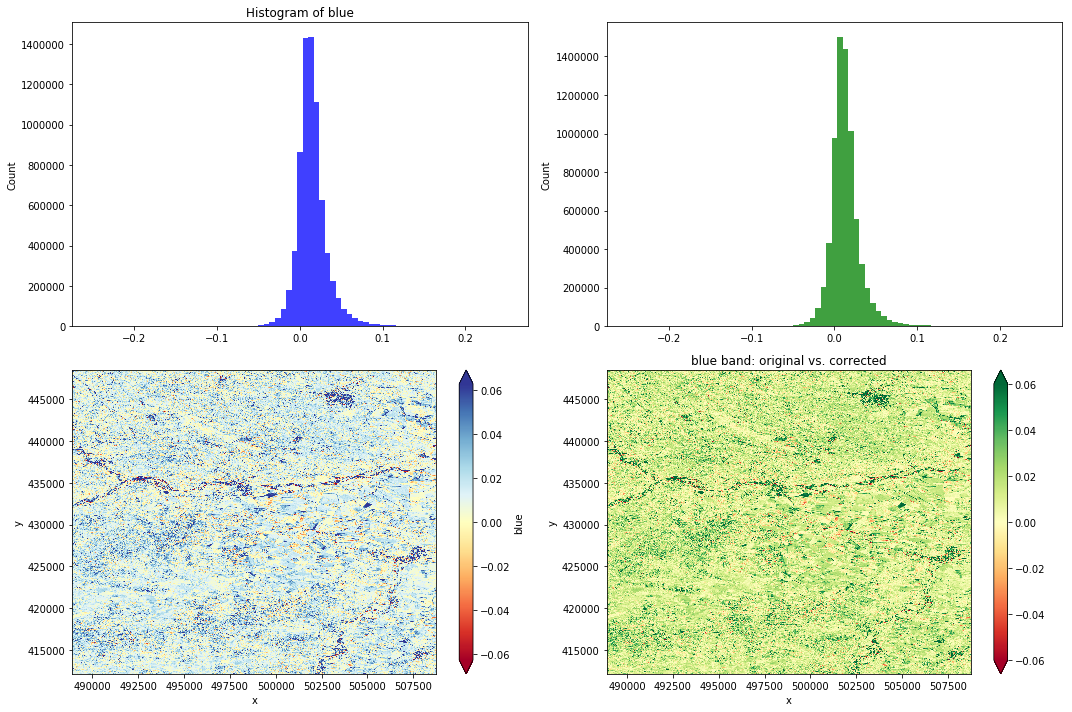

In [128]:
correct_band(subset, 'blue')

red original: 2.5939178524353315e-06 +- 6.62145848826099e-06
red corected: -6.659136965043434e-09 +- 5.6575379714502355e-06


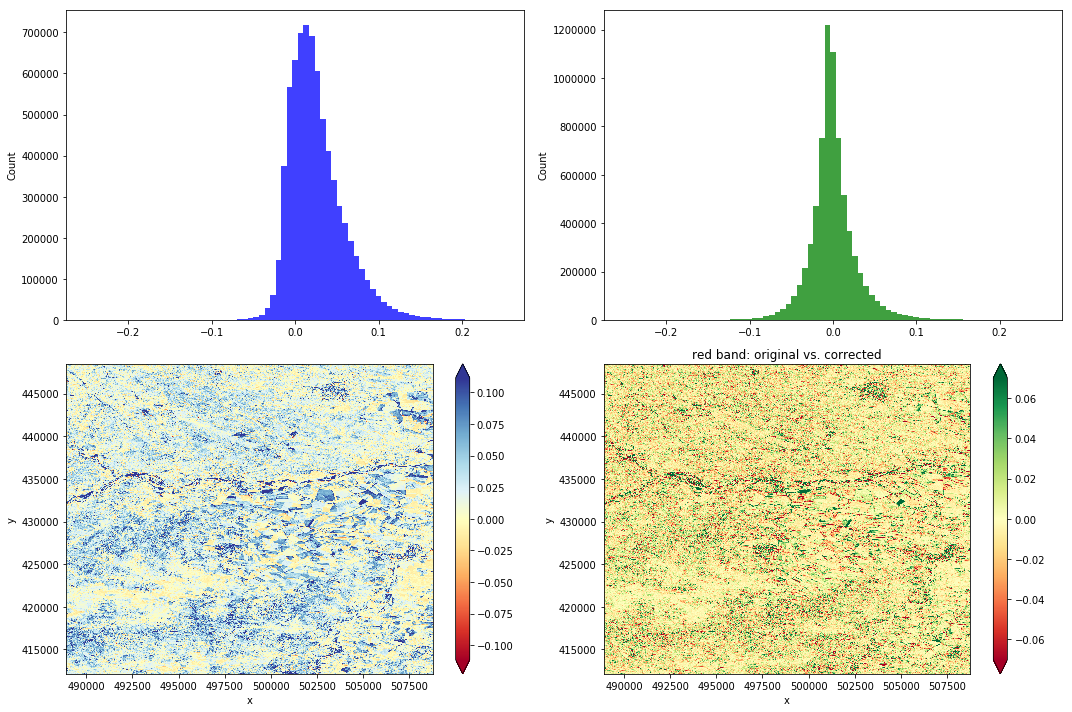

In [129]:
correct_band(subset, 'red')

green original: 3.6659047044146307e-06 +- 4.494529070792946e-06
green corected: 7.816268738318243e-07 +- 4.230510783360831e-06


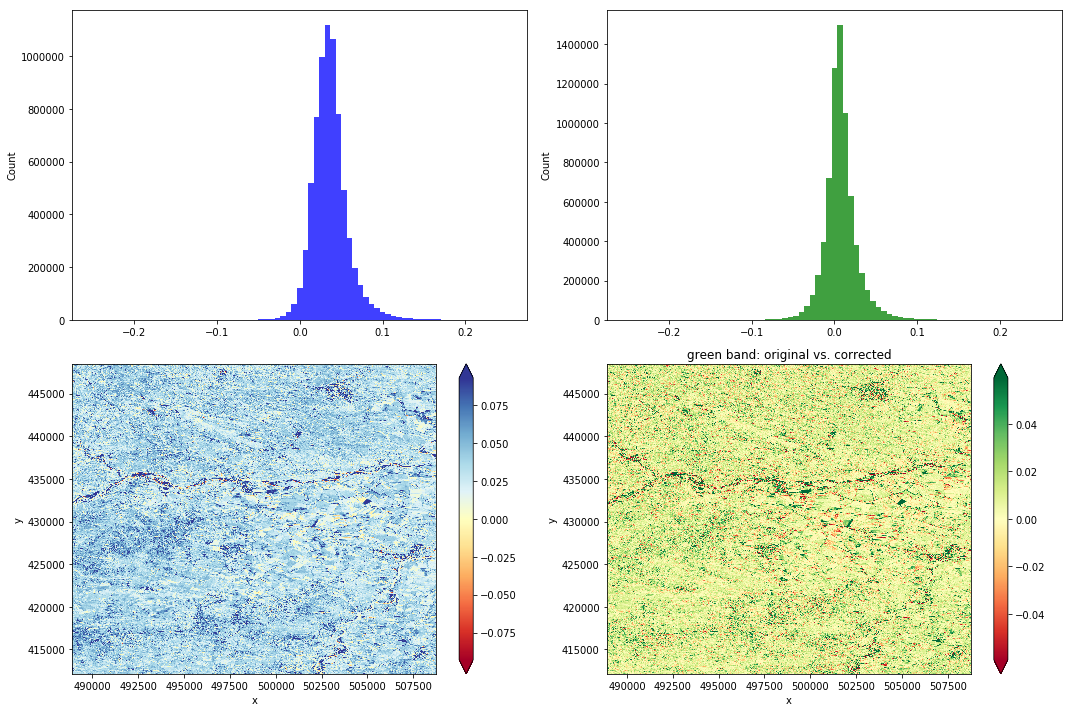

In [130]:
correct_band(subset, 'green')

nir original: 2.3381695261757856e-05 +- 1.4637651979576061e-05
nir corected: -2.4254899245177393e-06 +- 9.110986588894559e-06


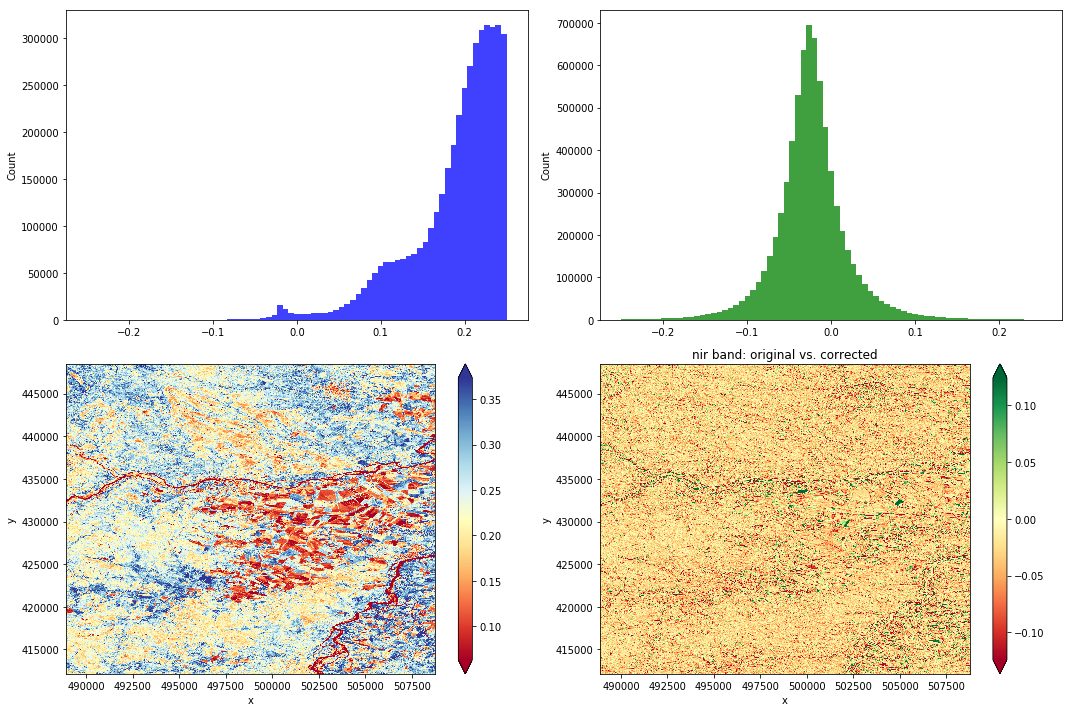

In [131]:
correct_band(subset, 'nir')

swir1 original: 2.084833787838643e-05 +- 1.2726453989387504e-05
swir1 corected: 1.6524475083535639e-06 +- 8.695640709259821e-06


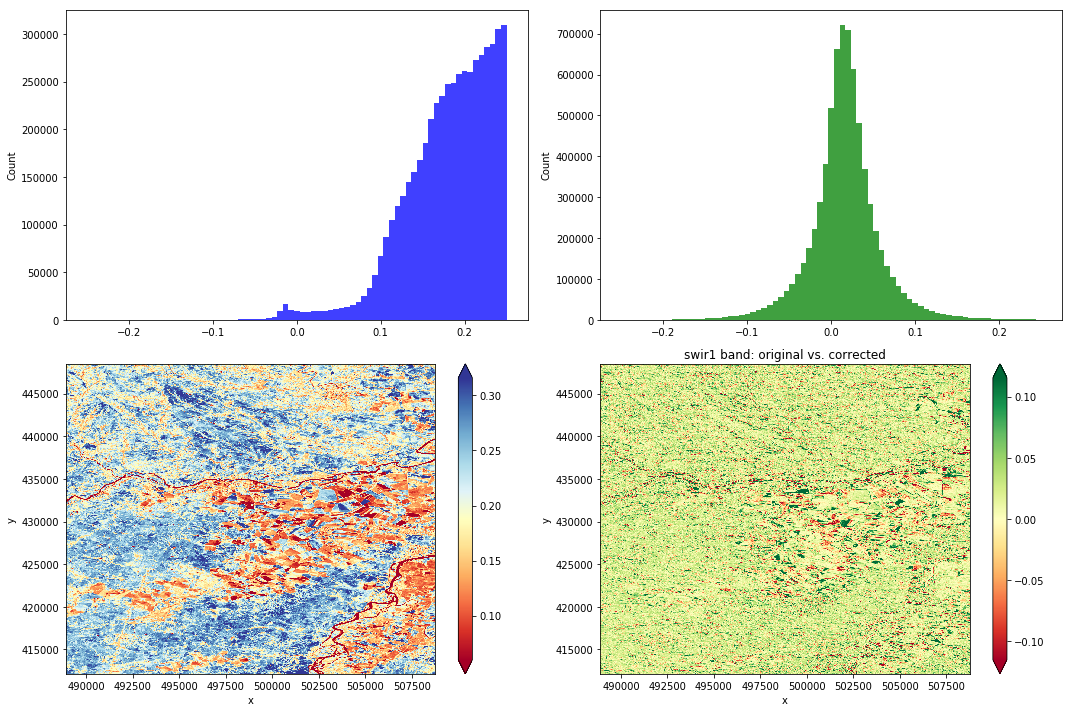

In [132]:
correct_band(subset, 'swir1')

swir2 original: 1.1242924429917308e-05 +- 1.0736412628397803e-05
swir2 corected: 1.9394820647470517e-06 +- 7.639673752072341e-06


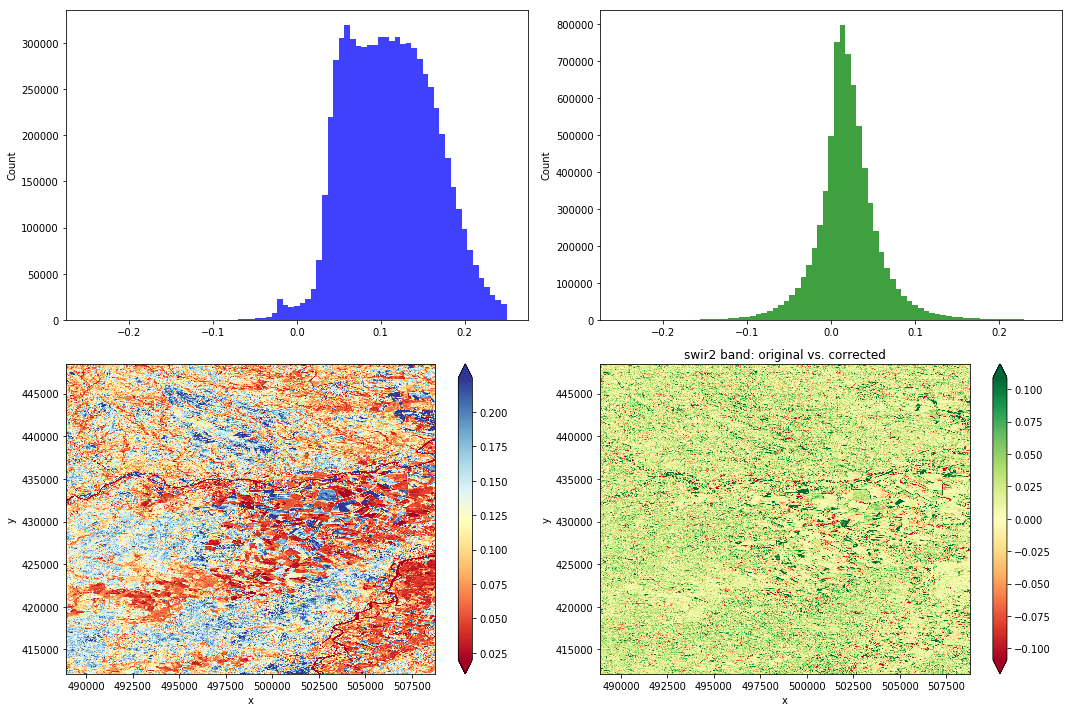

In [133]:
correct_band(subset, 'swir2')